# Notebook de préparation des données et modélisation

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# import lightgbm as lgb
# import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder


pd.set_option("display.max_columns", 50)

todo
outliers

In [80]:
df = pd.read_csv(filepath_or_buffer="./data/train.csv", sep=",")

In [81]:
df[[col for col in df.columns if not "V" in col]].dtypes.sort_values()

is_reply               bool
is_retweet             bool
contains_video         bool
contains_image         bool
engagement            int64
timestamp             int64
feature1              int64
feature2              int64
followers             int64
word_count            int64
shared_url_count      int64
language             object
author               object
shared_url_domain    object
dtype: object

Ce notebook se divise en trois parties : 
* Mise en place d'une pipeline de transformation des données
* Sélection d'un modèle 
* Optimisation des paramètres

## I. Mise en place d'une pipeline de transformation des données

D'après [l'analyse statistique des données](.\01_statistical_analysis.ipynb), on dispose de trois types de données qui ont été analysées une par une pour identifier des approches potentielles de transformations intéressantes.


|   Variable   |   Type   |   Approche |
|---    |:-:    |--:    |
|   is_reply   |   bool   |      |
|   is_retweet   |   bool   |   Suppression   |
|   contains_video   |   bool   |      |
|   contains_image   |   bool   |      |
|   **engagement**   |   int64   |   transformation log   |
|   timestamp   |   int64   |   extraction jour, mois, heure + transformation log(max-x)   |
|   feature1   |   int64   |   extraction de feature1_is_max & sélection des données non max   |
|   feature2   |   int64   |      |
|   followers   |   int64   |   transformation log   |
|   word_count   |   int64   |   transformation log transformation log(x+1)  |
|   shared_url_count   |   int64   |   extraction de is_shared_url **uniquement pour le moment**    |
|   language   |   object   |   Suppression   |
|   author   |   object   |   **pour le moment suppression**   |
|   shared_url_domain   |   object   |   extraction binnée du domaine et de l'extension   |

#### a. outliers exclusion

In [82]:
df.head()

,engagement,timestamp,language,feature1,feature2,followers,author,word_count,shared_url_count,shared_url_domain,is_reply,is_retweet,contains_video,contains_image,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1000,V1001,V1002,V1003,V1004,V1005,V1006,V1007,V1008,V1009,V1010,V1011,V1012,V1013,V1014,V1015,V1016,V1017,V1018,V1019,V1020,V1021,V1022,V1023,V1024
0,15,1655784230254,en,73,0,696,bd20432d80dfe4825a7a106312bda52e,18,0,NaN,False,False,False,True,0.010209,-0.000056,-0.000666,0.013120,0.005126,0.001000,0.013217,0.086126,0.016478,0.002729,0.043539,...,-0.000021,0.000277,0.019307,0.010259,0.044691,0.028100,0.023241,0.007108,5.303996e-05,0.000707,0.056702,0.008670,-0.000175,-0.001363,0.001299,0.066302,-0.002309,0.006296,-0.003366,0.055845,0.002813,0.030930,0.040009,0.017094,0.047829
1,91007,1655599613254,en,100,5,17526,71e2ecc6cc1d6515a6b122fab4c63bfc,15,0,NaN,False,False,False,False,0.029649,-0.000008,0.000608,0.013611,0.019315,0.010607,0.015242,0.075310,0.002251,0.006700,0.030039,...,-0.000573,0.000073,0.005532,0.007983,0.038882,0.047019,0.020805,0.001928,-1.218344e-07,0.007011,0.024635,0.017761,-0.000891,-0.001432,0.001263,0.020109,0.014174,0.019271,0.011605,-0.001049,0.018731,0.008732,0.034822,0.042102,0.020760
2,3,1655788872254,en,0,-5,239,2a9109f38d90a2a96e284a07c1a57e9b,8,0,NaN,True,False,False,False,0.036175,-0.000053,0.046600,0.006191,-0.002715,0.004963,-0.001282,0.067732,-0.000098,0.012590,0.042196,...,0.003328,0.001767,0.024704,0.012422,0.020508,0.010454,0.005297,0.012263,4.043737e-02,-0.000712,-0.000318,0.110239,0.003467,-0.002236,0.000999,0.069541,0.094191,-0.002353,0.030343,0.004930,0.000064,0.007801,0.006239,0.020304,0.032962
3,11,1655788810254,en,100,-5,21531,efea6800044f4b9b1df1d74031b4e027,49,0,NaN,False,False,False,False,0.031348,-0.000005,0.003516,0.017923,0.013227,0.004100,0.008787,0.095869,0.001441,0.011418,0.034261,...,0.001302,-0.000240,0.018017,-0.000095,0.044092,0.023696,0.046780,0.008945,-2.658587e-04,0.012014,0.008401,0.000471,0.029090,-0.001372,0.000634,0.040541,0.022897,0.003639,0.002614,-0.000489,0.006744,0.031689,0.018264,0.010356,0.024227
4,235,1655789250254,en,100,5,101278,48b2b1f1d75321a4c30d6ff325c1c776,7,0,NaN,False,False,False,False,0.003628,-0.000014,0.006928,-0.001991,0.002341,0.003439,-0.000505,0.064887,0.015366,0.005833,0.064873,...,0.001822,0.000829,-0.000689,0.003365,0.058259,0.035081,0.035536,-0.000854,8.054050e-03,0.000292,0.047827,0.037066,-0.000380,-0.000970,0.000761,0.048198,0.002539,0.002455,0.007407,0.000310,0.000414,0.023624,0.045199,0.023351,0.030259


In [83]:
df = df.query("followers > 0 & word_count > 0")

#### b. transformation

In [84]:
df.drop(columns=["language", "author", "is_retweet"], inplace=True)

In [85]:
def split_url(url):
    if not isinstance(url, str):
        return (np.nan, np.nan)

    url = url[7:-1]
    url_split = url.split(".")
    radical = url_split[0]
    extension = ".".join(url_split[1:])
    return (radical, extension)

shared_url_domain

In [86]:
shared_url_split_df = df["shared_url_domain"].apply(split_url).apply(pd.Series)

# Radical
radical_freq_series = shared_url_split_df[0].value_counts()
shared_url_split_df[0] = shared_url_split_df[0].map(lambda x: x if (radical_freq_series.get(x, 3) > 2) else "other")

# Extension
extension_freq_series = shared_url_split_df[1].value_counts()
shared_url_split_df[1] = shared_url_split_df[1].map(lambda x: x if (extension_freq_series.get(x, 1) > 1) else "other")

# Assignation
df[["shared_url_radical", "shared_url_extension"]] = shared_url_split_df

# Encoding
df_encoded = pd.get_dummies(df, columns=["shared_url_radical", "shared_url_extension"])

shared_url_count

In [87]:
df_encoded["is_shared_url"] = df_encoded["shared_url_count"] > 0

timestamp

In [88]:
timestamp_datetime_series = pd.to_datetime(df_encoded["timestamp"], unit='ms')

df_encoded["month_post"] = timestamp_datetime_series.dt.month
df_encoded["day_of_week_post"] = timestamp_datetime_series.dt.dayofweek
df_encoded["hour_post"] = timestamp_datetime_series.dt.hour

In [89]:
max_timestamp = df_encoded["timestamp"].max()
df_encoded["timestamp"] = df_encoded["timestamp"].apply(lambda x: np.log10(max_timestamp + 1 - x)).replace(-np.inf, 0)

word_count, engagement, followers

In [90]:
df_encoded["word_count"] = df_encoded["word_count"].apply(lambda x: np.log10(x+1))
df_encoded["engagement"] = df_encoded["engagement"].apply(np.log10).replace(-np.inf, 0)
df_encoded["followers"] = df_encoded["followers"].apply(np.log10)


feature1

In [91]:
max_feature1 = df_encoded["feature1"].max()
df_encoded["feature1_is_max"] = df_encoded["feature1"] == max_feature1

In [92]:
df_encoded.drop(columns=["feature1", "shared_url_count", "shared_url_domain"], inplace=True)

embedding

In [93]:
n_components = 20

V_cols = [col for col in df_encoded.columns if "V" in col]

pca = PCA(n_components=n_components)
V_reduced = pca.fit_transform(df_encoded[V_cols])

df_encoded_reduced = df_encoded.drop(columns=V_cols)
df_encoded_reduced[V_cols[:n_components]] = V_reduced

## II. Sélection d'un modèle

In [94]:
df_encoded_reduced.describe()

,engagement,timestamp,feature2,followers,word_count,month_post,day_of_week_post,hour_post,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
count,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03,4.150000e+03
mean,2.494849,6.914722,-0.392771,3.846755,1.206578,5.997831,1.186506,8.385060,-9.095803e-18,-1.712151e-18,1.926170e-18,-1.219908e-17,-2.300703e-18,-1.712151e-18,3.103274e-18,6.153043e-19,-8.293232e-19,-4.226873e-18,4.066359e-18,2.862503e-18,1.230609e-18,9.095803e-19,-3.544688e-18,-3.745331e-18,-1.765656e-18,-2.461217e-18,3.370798e-18,3.049769e-18
std,1.662583,1.064804,3.576111,1.312957,0.300797,0.046524,1.585792,7.294426,1.505268e-01,1.149547e-01,1.020451e-01,6.695146e-02,6.328260e-02,5.283841e-02,4.971289e-02,4.667385e-02,4.428769e-02,4.283736e-02,4.242081e-02,3.919783e-02,3.846742e-02,3.842620e-02,3.669756e-02,3.645234e-02,3.580839e-02,3.522116e-02,3.493324e-02,3.430784e-02
min,0.000000,0.000000,-5.000000,0.000000,0.301030,5.000000,0.000000,0.000000,-4.812429e-01,-2.958872e-01,-2.148781e-01,-3.295679e-01,-2.629406e-01,-1.927767e-01,-2.057090e-01,-1.423737e-01,-1.292741e-01,-1.612660e-01,-1.616284e-01,-1.396218e-01,-1.323633e-01,-1.208011e-01,-1.268828e-01,-1.364429e-01,-1.235606e-01,-1.353425e-01,-1.325971e-01,-1.135574e-01
25%,1.079181,6.143249,-5.000000,2.912488,1.000000,6.000000,0.000000,4.000000,-9.190336e-02,-8.793664e-02,-7.539844e-02,-3.718901e-02,-4.162032e-02,-3.465410e-02,-2.953324e-02,-2.912164e-02,-3.105334e-02,-2.903570e-02,-2.892098e-02,-2.615026e-02,-2.546137e-02,-2.675696e-02,-2.569141e-02,-2.464581e-02,-2.420273e-02,-2.162277e-02,-2.399840e-02,-2.430297e-02
50%,2.688864,7.124227,0.000000,3.710540,1.204120,6.000000,1.000000,5.000000,1.344578e-02,-6.492817e-03,-1.027191e-02,-1.355611e-03,-3.397568e-04,9.178629e-04,2.165941e-03,-3.878116e-03,-4.626847e-03,1.406434e-03,-8.447562e-04,4.133532e-04,-1.202314e-03,-2.505345e-04,4.724471e-04,-1.744515e-03,-2.596280e-04,-9.733897e-04,-1.469660e-03,-3.120055e-04
75%,3.834834,7.691232,0.000000,4.693443,1.447158,6.000000,1.000000,15.000000,8.958462e-02,8.435606e-02,6.389293e-02,3.958220e-02,4.075850e-02,3.315059e-02,3.175046e-02,2.467704e-02,2.677724e-02,2.837022e-02,2.938414e-02,2.700866e-02,2.465558e-02,2.613243e-02,2.534902e-02,2.387612e-02,2.424910e-02,2.229007e-02,2.279752e-02,2.305609e-02
max,5.986976,9.382464,5.000000,7.970834,1.826075,6.000000,6.000000,23.000000,6.864092e-01,3.257271e-01,4.738133e-01,2.006339e-01,2.148679e-01,2.902124e-01,2.563261e-01,2.486620e-01,1.656678e-01,1.646030e-01,1.708880e-01,1.345065e-01,2.240911e-01,1.300419e-01,1.320179e-01,1.226923e-01,1.275675e-01,3.029639e-01,1.131941e-01,1.527141e-01


In [95]:
# Separation of the target
X = df_encoded_reduced.drop(columns=["engagement"])
y = df_encoded_reduced["engagement"]

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# Model training
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Eval on test split
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 score:", r2)

Mean Squared Error: 0.8366089040887965
R^2 score: 0.6928106408044594


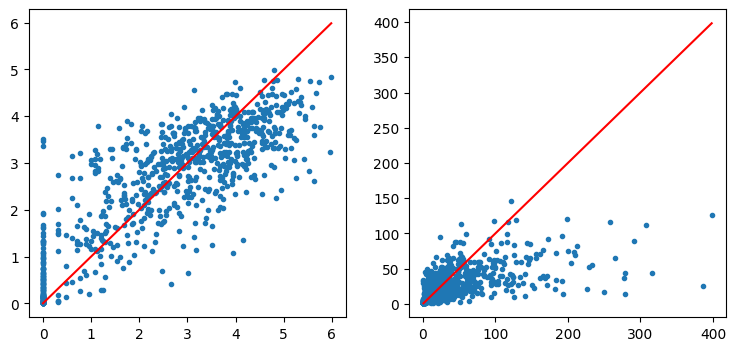

In [96]:
plt.figure(figsize=(9, 4))

# Figure log
plt.subplot(121)

val_range = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]

plt.plot(y_test, y_pred, ".")
plt.plot(val_range, val_range, "r-")


# Figure exp
plt.subplot(122)

y_test_exp, y_pred_exp = np.exp(y_test), np.exp(y_pred)

val_range = [min(y_test_exp.min(), y_pred_exp.min()), max(y_test_exp.max(), y_pred_exp.max())]
plt.plot(y_test_exp, y_pred_exp, ".")
plt.plot(val_range, val_range, "r-")

## III. Optimisation des paramètres

In [97]:
dfa = pd.read_csv(filepath_or_buffer="./data/train.csv", sep=",")
dfb = pd.read_csv(filepath_or_buffer="./data/authorData.csv", sep=",")

In [98]:
dfa.shape, dfb.shape

((4154, 1038), (629877, 14))

In [100]:
[col for col in dfa.columns if col not in dfb. columns and not "V" in col]

[]

In [101]:
[col for col in dfb.columns if col not in dfa. columns]

[]